<a href="https://colab.research.google.com/github/nikeshthapa255/AI-MLOPS/blob/main/DeepLabV3%2B_Lungs_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Lung Segmentation of Chest X-Ray dataset using DeepLabV3+

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture
- create a masked image (prediction)

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources - Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


## Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

## Grading = 10 Points

In [1]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-06-09 17:47:01--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M  39.2MB/s    in 3.4s    

2024-06-09 17:47:05 (39.2 MB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [2]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Model

def visualize_heatmap(model, image, class_index=0):
    """
    Visualizes the heatmap for a specified class index from the model's softmax output.

    Parameters:
    - model: The trained model.
    - image: The input image.
    - class_index: The index of the class to visualize the heatmap for (default is 0).
    """
    # Get the last layer output
    last_layer_output = model.layers[-1].output

    # Create a model to get the last layer output
    intermediate_model = Model(inputs=model.input, outputs=last_layer_output)

    # Get the intermediate output
    intermediate_output = intermediate_model.predict(np.expand_dims(image, axis=0))[0]

    # Extract the heatmap for the specified class index
    class_heatmap = intermediate_output[:, :, class_index]

    # Plot the original image and heatmap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(class_heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Heatmap of Class {class_index}")
    plt.axis('off')

    plt.show()


In [3]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation metrics from a Keras history object using subplots.

    Parameters:
    history (History): History object returned from model.fit()

    Returns:
    None
    """
    # Extracting metrics from the history object
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]

    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics))

    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one metric

    for i, metric in enumerate(metrics):
        axes[i].plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')

        axes[i].set_title(f'Training and Validation {metric.capitalize()}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
@tf.function
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

@tf.function
def iou(y_true, y_pred):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    sum_ = tf.keras.backend.sum(tf.keras.backend.abs(y_true) + tf.keras.backend.abs(y_pred), axis=[1, 2, 3])
    iou = intersection / (sum_ - intersection)
    return iou

### **PART-A**

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

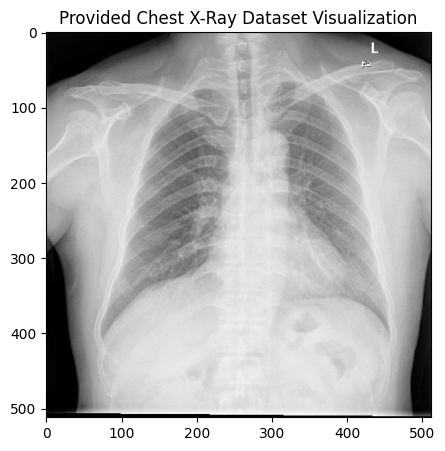

In [5]:
# Visualize an image
# Load the provided image
image_path = '/content/LungSegmentation/CXR_png/CHNCXR_0001_0.png'
def show_image_from_path(image_path):
    image = cv2.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.title('Provided Chest X-Ray Dataset Visualization')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# image = cv2.imread(image_path)

# # Display the image
# plt.figure(figsize=(10, 5))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.title('Provided Chest X-Ray Dataset Visualization')
# plt.axis('off')
# plt.show()

show_image_from_path(image_path)

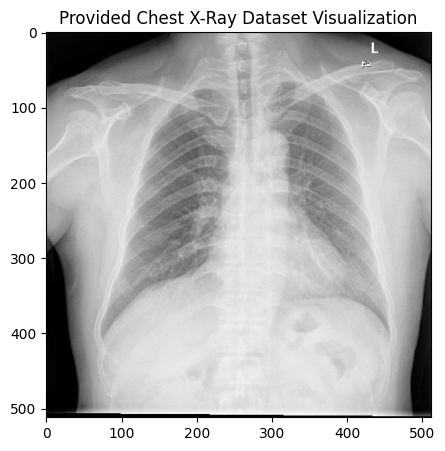

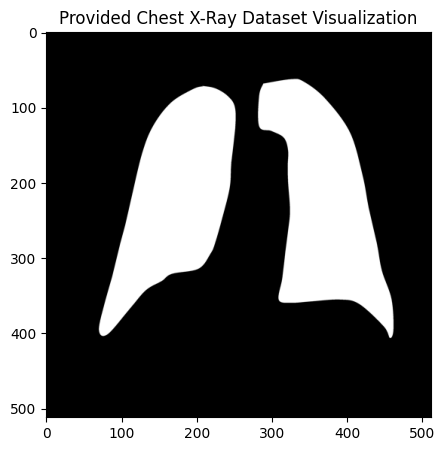

In [6]:
# Visualize a semantic part segmentation label image
# Example paths (replace these with the actual paths to your dataset)
image_path = '/content/LungSegmentation/CXR_png/CHNCXR_0001_0.png'
mask_path = '/content/LungSegmentation/masks/CHNCXR_0001_0.png'

show_image_from_path(image_path)
show_image_from_path(mask_path)


### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint:
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [7]:
from sklearn.model_selection import train_test_split
import os
import glob

IMAGE_SIZE = 256
BATCH_SIZE = 2
NUM_CLASSES = 2
DATA_DIR = "./LungSegmentation"


# Find paths for all the image files in the 'CXR_png' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_images = sorted(glob.glob(os.path.join(DATA_DIR, 'CXR_png', '*.png')))

# Find paths for all the mask files in the 'masks' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_masks = sorted(glob.glob(os.path.join(DATA_DIR, 'masks', '*.png')))

# Split the data into training, validation, and test sets
train_images, val_images, train_masks, val_masks = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.2, random_state=42)

# Print the number of images in each set
print(f"Total images: {len(all_images)}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

# Print the number of masks in each set
print(f"Total masks: {len(all_masks)}")
print(f"Training masks: {len(train_masks)}")
print(f"Validation masks: {len(val_masks)}")
print(f"Test masks: {len(test_masks)}")

Total images: 704
Training images: 563
Validation images: 112
Test images: 29
Total masks: 704
Training masks: 563
Validation masks: 112
Test masks: 29


In [8]:
def find_last_images_and_masks(train_images, train_masks, batch_size=BATCH_SIZE):

    # Calculate the number of full batches
    num_full_batches = len(train_images) // batch_size

    # Calculate the start index of the last incomplete batch
    start_index_last_incomplete_batch = num_full_batches * batch_size

    # Get the last few images and masks that are not part of a full batch
    last_images = train_images[start_index_last_incomplete_batch:]
    last_masks = train_masks[start_index_last_incomplete_batch:]

    return last_images, last_masks

last_images, last_masks = find_last_images_and_masks(train_images, train_masks, batch_size=4)

print("Last images not included in a full batch:", last_images)
print("Last masks not included in a full batch:", last_masks)

Last images not included in a full batch: ['./LungSegmentation/CXR_png/CHNCXR_0318_0.png', './LungSegmentation/CXR_png/CHNCXR_0526_1.png', './LungSegmentation/CXR_png/CHNCXR_0110_0.png']
Last masks not included in a full batch: ['./LungSegmentation/masks/CHNCXR_0318_0.png', './LungSegmentation/masks/CHNCXR_0526_1.png', './LungSegmentation/masks/CHNCXR_0110_0.png']


In [9]:
# Function to read an image file and returns a preprocessed image tensor.
def read_image(image_path, mask=False):
    # Load the image file
    image = keras.utils.load_img(image_path, color_mode='grayscale' if mask else 'rgb', target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # Convert the image to an array
    image = keras.utils.img_to_array(image)
    # Normalize the pixel values to [0, 1] for images, and keep masks as [0, 1]
    image = image / 255.0
    if mask:
        image = tf.cast(image, tf.uint8)  # Cast the mask to uint8 type
        image = tf.squeeze(image, axis=-1)  # Remove the last dimension
        image = tf.one_hot(image, depth=2)  # Convert the mask to one-hot encoding
    return image

Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [10]:
def load_data(image_path, mask_path):
    image = read_image(image_path, mask=False)
    mask = read_image(mask_path, mask=True)
    return image, mask

Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments.

The function should:
- create a **tf.data.Dataset** object from the input data
- map the **load_data** function to each element in the dataset
- convert the dataset into batches of size **BATCH_SIZE**, drop any incomplete batch at the end of the dataset
- return the resulting dataset

In [11]:
# Generate train and validation set
def data_generator(image_list, mask_list, batch_size=BATCH_SIZE):
    # Create a TensorFlow Dataset object from the input data
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

    # Map the load_data function to each element in the dataset
    dataset = dataset.map(lambda img, msk: tf.numpy_function(load_data, [tf.convert_to_tensor(img), msk], [tf.float32, tf.float32]),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset and drop any incomplete batch at the end of the dataset
    dataset = dataset.cache().batch(batch_size, drop_remainder=True)

    # Prefetch the dataset for better performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset



In [12]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)


Check the total images for train and validation.

In [13]:
# Show one example for train dataset
for example in train_dataset.take(1):
    images, masks = example
    print("Images shape: ", images.shape)
    print("Masks shape: ", masks.shape)


Images shape:  (2, 256, 256, 3)
Masks shape:  (2, 256, 256, 2)



Check the number of batches formed in train and validation set.


In [14]:
num_train_batches = 0
for _ in train_dataset:
    num_train_batches += 1

num_val_batches = 0
for _ in val_dataset:
    num_val_batches += 1

print('Train batch count:\t', num_train_batches, '\nValidation batch count:\t', num_val_batches)

Train batch count:	 281 
Validation batch count:	 56


Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### **PART-B**

### Unet

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_dataset and val_dataset are already created as shown in your provided code


In [16]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [17]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [18]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks.

  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs


In [21]:
def unet_model(input_shape: tuple = (128, 128, 3), num_classes: int = 2):  # Update input size to have 1 channel for grayscale images
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=num_classes)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [20]:
model_unet = unet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=2)
model_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coefficient, iou], run_eagerly=True)
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [22]:
# configure the training parameters and train the model

TRAIN_LENGTH = len(train_images)
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = len(val_images) // BATCH_SIZE // VAL_SUBSPLITS

model_history = model_unet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)


Epoch 1/10


281/281 [==============================] - 49s 121ms/step - loss: 0.3549 - dice_coefficient: 0.8045 - iou: 0.6850 - val_loss: 0.2464 - val_dice_coefficient: 0.8676 - val_iou: 0.7668
Epoch 2/10
281/281 [==============================] - 34s 121ms/step - loss: 0.1204 - dice_coefficient: 0.9312 - iou: 0.8724 - val_loss: 0.1018 - val_dice_coefficient: 0.9308 - val_iou: 0.8709
Epoch 3/10
281/281 [==============================] - 34s 120ms/step - loss: 0.0918 - dice_coefficient: 0.9483 - iou: 0.9023 - val_loss: 0.0886 - val_dice_coefficient: 0.9396 - val_iou: 0.8865
Epoch 4/10
281/281 [==============================] - 34s 120ms/step - loss: 0.0766 - dice_coefficient: 0.9569 - iou: 0.9178 - val_loss: 0.0731 - val_dice_coefficient: 0.9504 - val_iou: 0.9059
Epoch 5/10
281/281 [==============================] - 34s 120ms/step - loss: 0.1000 - dice_coefficient: 0.9449 - iou: 0.8977 - val_loss: 0.0670 - val_dice_coefficient: 0.9606 - val_iou: 0.9244
Epoch 6/10
281/281 [==========================

#### Visualize heatmap

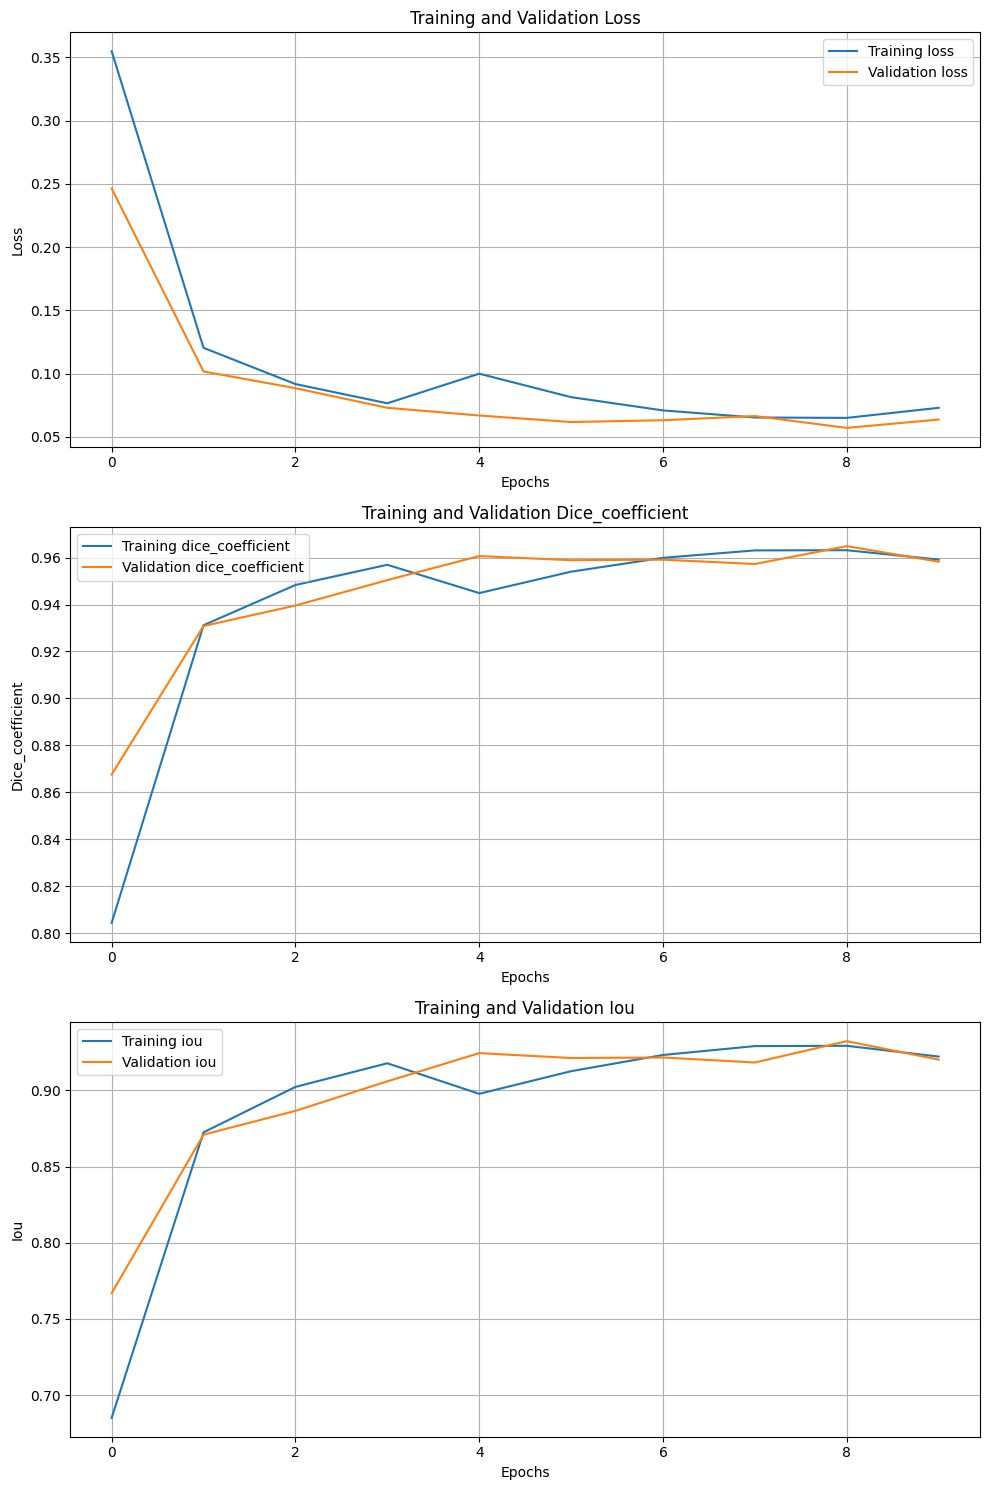

1/1 [==============================] - 2s 2s/step


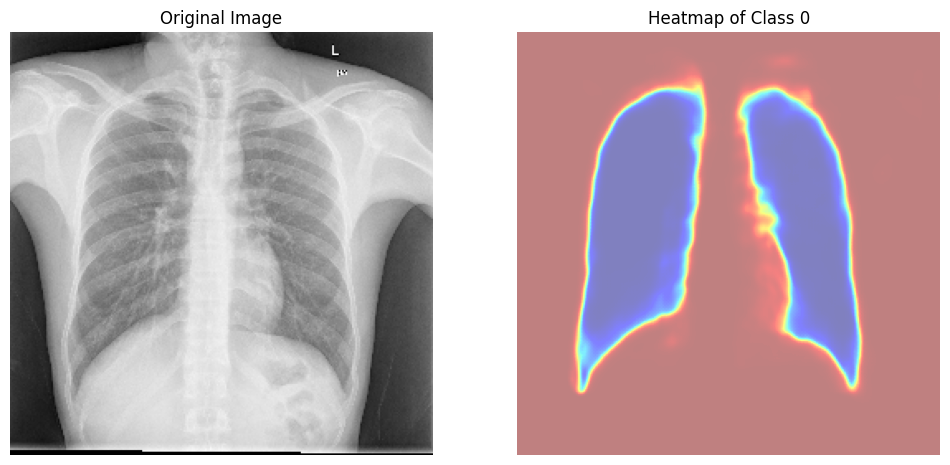

**************************
 TEST MASK


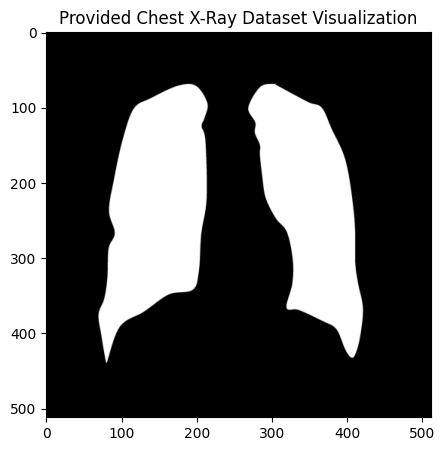

In [23]:
plot_training_history(model_history)

# Load a sample image and mask
# sample_image, sample_mask = next(iter(val_dataset))
TEST_INDEX = 1
sample_image, sample_mask = load_data(test_images[TEST_INDEX], test_masks[TEST_INDEX])
sample_image = sample_image

visualize_heatmap(model_unet, sample_image)

print('**************************\n TEST MASK')
show_image_from_path(test_masks[TEST_INDEX])


### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points)
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def convolution_block(x: tf.Tensor, filters: int, kernel_size: int = 3, dilation_rate: int = 1, padding: str = "same", use_bias: bool = False) -> tf.Tensor:
    """
    Convolutional block with Conv2D, BatchNormalization, and ReLU activation.
    """
    x = layers.Conv2D(filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [ ]:
def dilated_spatial_pyramid_pooling(x: tf.Tensor) -> tf.Tensor:
    """
    Dilated Spatial Pyramid Pooling (ASPP) block with different dilation rates and image-level pooling.
    """
    dims = tf.shape(x)
    pool_size = (dims[1], dims[2])

    # Atrous convolutions with different dilation rates
    atrous_block1 = convolution_block(x, 256, kernel_size=1, dilation_rate=1)
    atrous_block6 = convolution_block(x, 256, kernel_size=3, dilation_rate=6)
    atrous_block12 = convolution_block(x, 256, kernel_size=3, dilation_rate=12)
    atrous_block18 = convolution_block(x, 256, kernel_size=3, dilation_rate=18)

    # Image pooling
    image_pooling = layers.GlobalAveragePooling2D()(x)
    image_pooling = layers.Reshape((1, 1, x.shape[-1]))(image_pooling)  # Changed to use x.shape[-1]
    image_pooling = convolution_block(image_pooling, 256, kernel_size=1)

    # Use Lambda layer to dynamically extract the dimensions for upsampling
    upsample_size = layers.Lambda(lambda t: tf.shape(t)[1:3])(x)
    image_pooling = layers.Lambda(lambda args: tf.image.resize(args[0], args[1], method=tf.image.ResizeMethod.BILINEAR))([image_pooling, upsample_size])


    # Concatenate all the atrous and image pooling blocks
    x = layers.Concatenate()([atrous_block1, atrous_block6, atrous_block12, atrous_block18, image_pooling])
    x = convolution_block(x, 256, kernel_size=1)
    return x

The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [ ]:
def encoder_block(input_tensor: tf.Tensor) -> tuple:
    """
    Encoder block using ResNet50 as the base model.
    """
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = dilated_spatial_pyramid_pooling(x)
    return resnet50, x

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [ ]:

def decoder_block(x: tf.Tensor, low_level_features: tf.Tensor) -> tf.Tensor:
    """
    Decoder block for DeepLabV3+ model.
    """
    low_level_features = convolution_block(low_level_features, 48, kernel_size=1)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, low_level_features])
    x = convolution_block(x, 256)
    x = convolution_block(x, 256)
    return x

In [ ]:
def DeepLabV3PlusFunction(input_shape: tuple = (128, 128, 3), num_classes: int = 21) -> tf.keras.Model:
    """
    DeepLabV3+ model with customizable input shape and number of output classes.
    """
    inputs = tf.keras.Input(shape=input_shape)
    base_model, encoder_output = encoder_block(inputs)
    low_level_features = base_model.get_layer("conv2_block3_2_relu").output
    decoder_output = decoder_block(encoder_output, low_level_features)
    decoder_output = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(decoder_output)
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(decoder_output)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [ ]:

class DeepLabV3Plus:
    def __init__(self, input_shape: tuple = (128, 128, 3), num_classes: int = 21):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def convolution_block(self, x: tf.Tensor, filters: int, kernel_size: int = 3, dilation_rate: int = 1, padding: str = "same", use_bias: bool = False) -> tf.Tensor:
        """
        Convolutional block with Conv2D, BatchNormalization, and ReLU activation.
        """
        x = layers.Conv2D(filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, use_bias=use_bias)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def dilated_spatial_pyramid_pooling(self, x: tf.Tensor) -> tf.Tensor:
        """
        Dilated Spatial Pyramid Pooling (ASPP) block with different dilation rates and image-level pooling.
        """
        dims = tf.shape(x)
        pool_size = (dims[1], dims[2])

        # Atrous convolutions with different dilation rates
        atrous_block1 = self.convolution_block(x, 256, kernel_size=1, dilation_rate=1)
        atrous_block6 = self.convolution_block(x, 256, kernel_size=3, dilation_rate=6)
        atrous_block12 = self.convolution_block(x, 256, kernel_size=3, dilation_rate=12)
        atrous_block18 = self.convolution_block(x, 256, kernel_size=3, dilation_rate=18)

        # Image pooling
        image_pooling = layers.GlobalAveragePooling2D()(x)
        image_pooling = layers.Reshape((1, 1, x.shape[-1]))(image_pooling)  # Changed to use x.shape[-1]
        image_pooling = self.convolution_block(image_pooling, 256, kernel_size=1)

        # Use Lambda layer to dynamically extract the dimensions for upsampling
        upsample_size = layers.Lambda(lambda t: tf.shape(t)[1:3])(x)
        image_pooling = layers.Lambda(lambda args: tf.image.resize(args[0], args[1], method=tf.image.ResizeMethod.BILINEAR))([image_pooling, upsample_size])

        # Concatenate all the atrous and image pooling blocks
        x = layers.Concatenate()([atrous_block1, atrous_block6, atrous_block12, atrous_block18, image_pooling])
        x = self.convolution_block(x, 256, kernel_size=1)
        return x

    def encoder_block(self, input_tensor: tf.Tensor) -> tuple:
        """
        Encoder block using ResNet50 as the base model.
        """
        resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor)
        x = resnet50.get_layer("conv4_block6_2_relu").output
        x = self.dilated_spatial_pyramid_pooling(x)
        return resnet50, x

    def decoder_block(self, x: tf.Tensor, low_level_features: tf.Tensor) -> tf.Tensor:
        """
        Decoder block for DeepLabV3+ model.
        """
        low_level_features = self.convolution_block(low_level_features, 48, kernel_size=1)
        x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
        x = layers.Concatenate()([x, low_level_features])
        x = self.convolution_block(x, 256)
        x = self.convolution_block(x, 256)
        return x

    def build_model(self) -> tf.keras.Model:
        """
        Build the DeepLabV3+ model.
        """
        inputs = tf.keras.Input(shape=self.input_shape)
        base_model, encoder_output = self.encoder_block(inputs)
        low_level_features = base_model.get_layer("conv2_block3_2_relu").output
        decoder_output = self.decoder_block(encoder_output, low_level_features)
        decoder_output = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(decoder_output)
        outputs = layers.Conv2D(self.num_classes, kernel_size=1, activation='softmax')(decoder_output)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def compile(self, optimizer, loss, metrics, run_eagerly=False):
        """
        Compile the DeepLabV3+ model.
        """
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics, run_eagerly=run_eagerly)

    def summary(self):
        """
        Print the model summary.
        """
        self.model.summary()

    def plot_model(self, show_shapes=True, to_file='model.png'):
        """
        Plot the model architecture.
        """
        tf.keras.utils.plot_model(self.model, show_shapes=show_shapes, to_file=to_file)

In [ ]:
model_deeplabv3 = DeepLabV3Plus(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=2).build_model()
model_deeplabv3.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

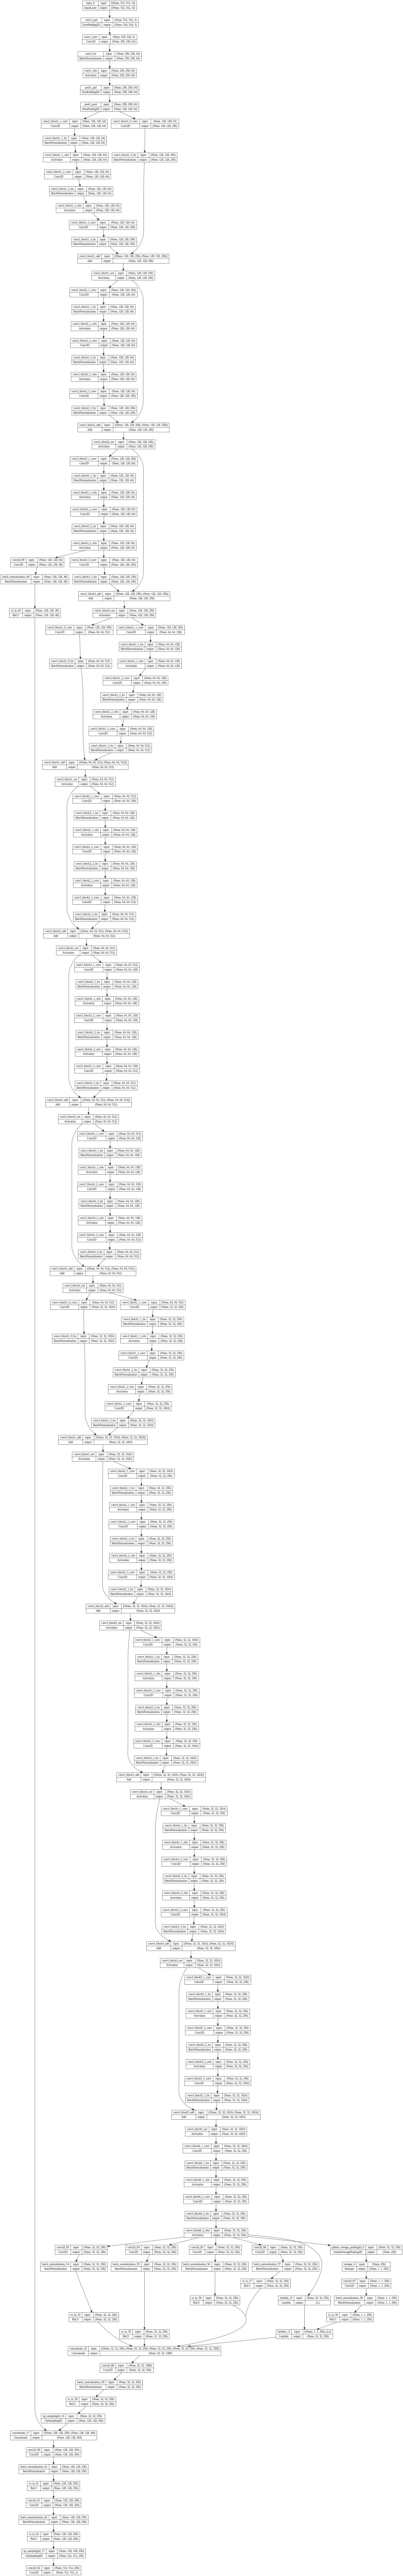

In [ ]:
tf.keras.utils.plot_model(model_deeplabv3, show_shapes=True)

### Training (1 point)

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

##### Compile model


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_deeplabv3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[dice_coefficient, iou, 'accuracy'], run_eagerly=True)

##### Model Training

In [ ]:
# configure the training parameters and train the model
TRAIN_LENGTH = len(train_images)
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = len(val_images) // BATCH_SIZE // VAL_SUBSPLITS

model_history = model_deeplabv3.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)


Epoch 1/10
140/140 [==============================] - 82s 446ms/step - loss: 0.1044 - dice_coefficient: 0.9417 - iou: 0.8982 - accuracy: 0.9577 - val_loss: 0.7079 - val_dice_coefficient: 0.6658 - val_iou: 0.4995 - val_accuracy: 0.6970
Epoch 2/10
140/140 [==============================] - 61s 435ms/step - loss: 0.0460 - dice_coefficient: 0.9725 - iou: 0.9466 - accuracy: 0.9826 - val_loss: 0.9140 - val_dice_coefficient: 0.7476 - val_iou: 0.5986 - val_accuracy: 0.7544
Epoch 3/10
140/140 [==============================] - 61s 435ms/step - loss: 0.0346 - dice_coefficient: 0.9785 - iou: 0.9580 - accuracy: 0.9862 - val_loss: 1.0387 - val_dice_coefficient: 0.7608 - val_iou: 0.6158 - val_accuracy: 0.7639
Epoch 4/10
140/140 [==============================] - 61s 439ms/step - loss: 0.0274 - dice_coefficient: 0.9828 - iou: 0.9662 - accuracy: 0.9891 - val_loss: 1.0188 - val_dice_coefficient: 0.7628 - val_iou: 0.6184 - val_accuracy: 0.7638
Epoch 5/10
140/140 [==============================] - 61s 43

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#####  Learning curve from model history (1 point)

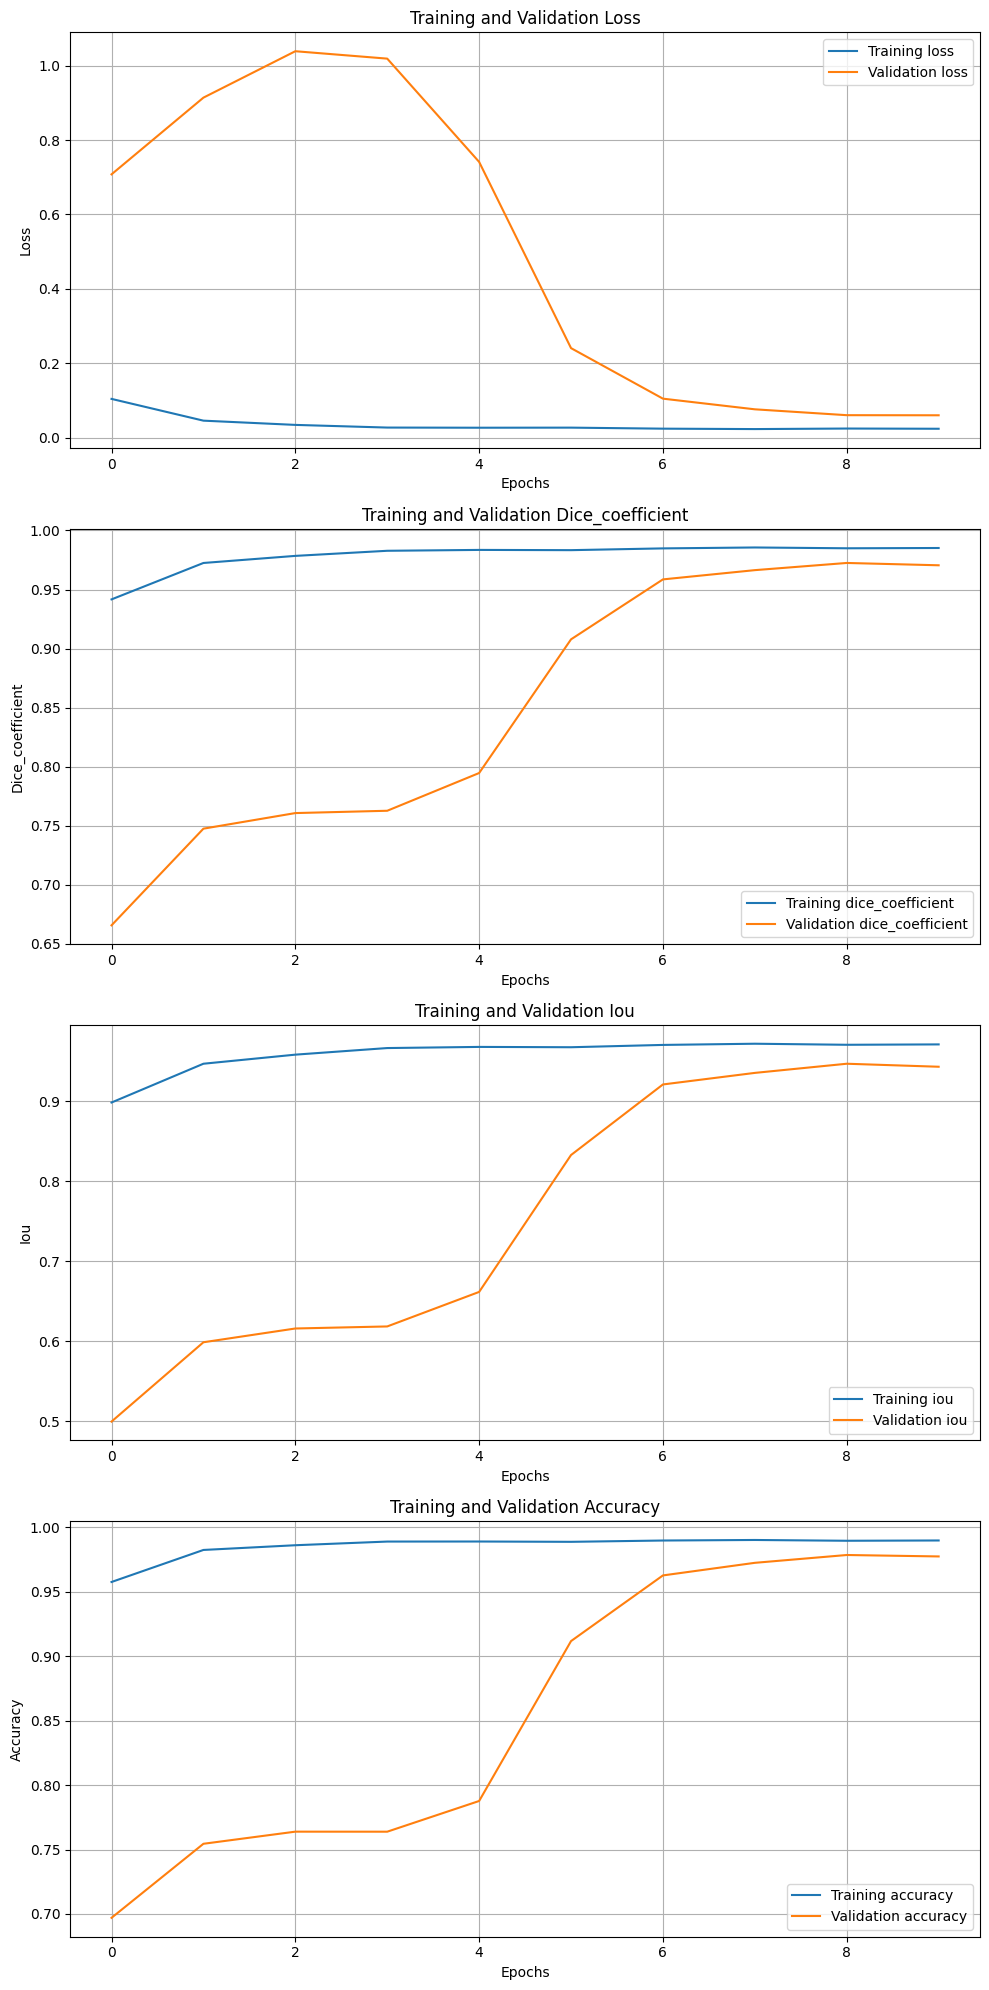

In [ ]:

plot_training_history(model_history)

### Visualize Predictions (1 points)

1/1 [==============================] - 1s 934ms/step


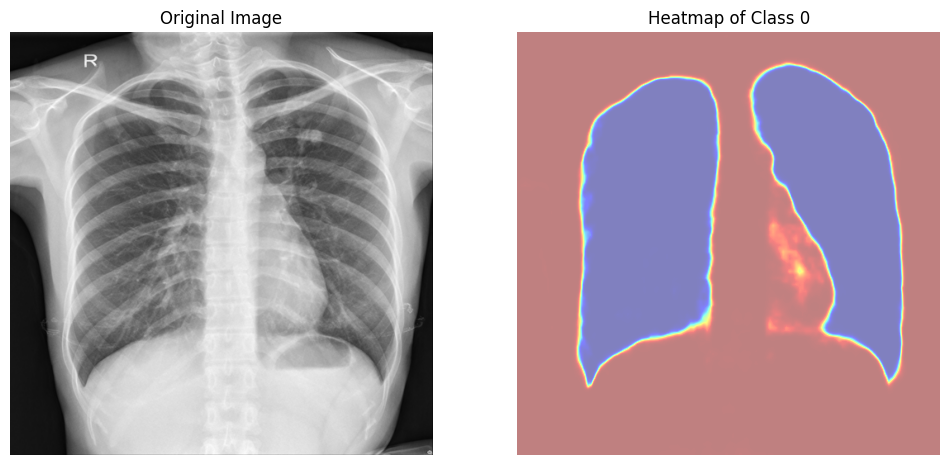

**************************
 TEST MASK


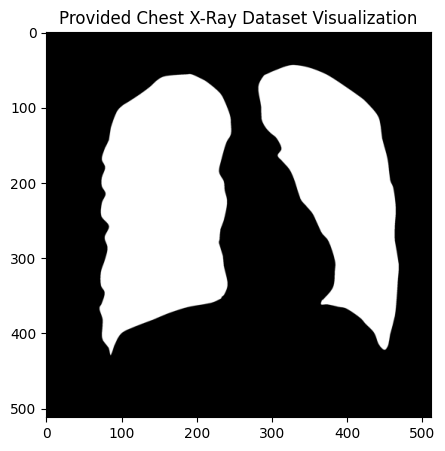

In [ ]:

# Load a sample image and mask
# sample_image, sample_mask = next(iter(val_dataset))
TEST_INDEX = 0
sample_image, sample_mask = load_data(test_images[TEST_INDEX], test_masks[TEST_INDEX])

visualize_heatmap(model_deeplabv3, sample_image)


print('**************************\n TEST MASK')
show_image_from_path(test_masks[TEST_INDEX])

# evaluate = model.evaluate([sample_image])
# print('=================>\n Evaluate', evaluate)


#### Save the model in drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

model_path = 'AI MLOps/Trained_models/lungs_segmentation_deeplabv3'
def save_model_to_drive(model, model_path):
    actual_path = '/content/drive/MyDrive/' + model_path
    # Save the model
    model.save(actual_path)
    print(f'Model saved to {model_path}')

save_model_to_drive(model_deeplabv3, model_path)
# model_deeplabv3.save(model_path)

Model saved to AI MLOps/Trained_models/lungs_segmentation_deeplabv3


Load the model

In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/AI MLOps/Trained_models/lungs_segmentation_deeplabv3'

loaded_model = tf.keras.models.load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient, 'iou': iou})
print('Model loaded successfully')
loaded_model.summary()

Model loaded successfully
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                             

1/1 [==============================] - 1s 1s/step


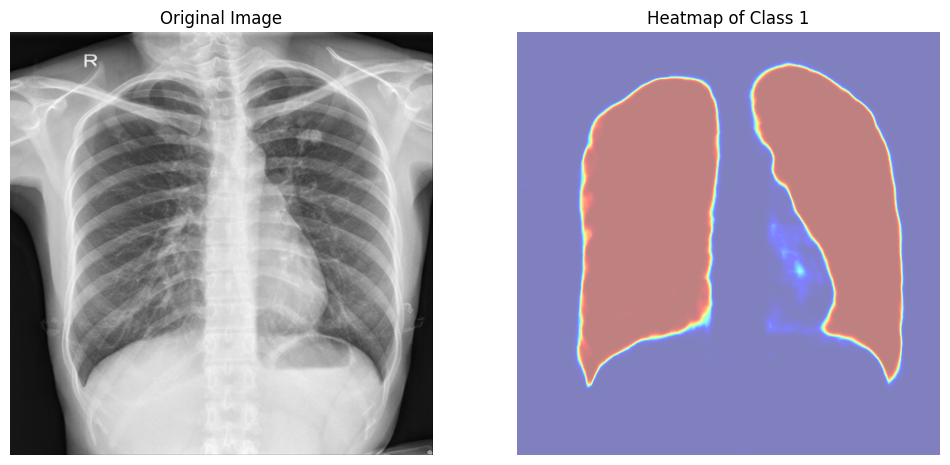

**************************
 TEST MASK


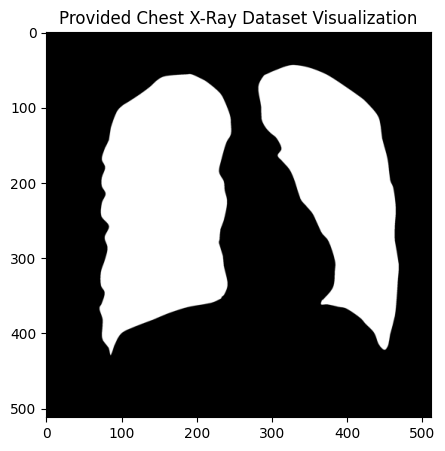

In [ ]:
TEST_INDEX = 0
sample_image, sample_mask = load_data(test_images[TEST_INDEX], test_masks[TEST_INDEX])

visualize_heatmap(loaded_model, sample_image)


print('**************************\n TEST MASK')
show_image_from_path(test_masks[TEST_INDEX])